In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearnex import patch_sklearn, config_context
patch_sklearn()

c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data preparation, cleaning and EDA

Please download the dataset from here and unzip and place it in the same directoey as this ipynb file. 
Link to download: https://www.kaggle.com/datasets/felix4guti/traffic-violations-in-usa?select=Traffic_Violations.csv
You need to be logged in to Kaggle to download it.

In [24]:
df = pd.read_csv("Traffic_Violations.csv")

# Giving the dimension information
print('Dataframe dimensions:', df.shape)

# dropping duplicates:
print(f"The number of rows in the dataframe are: {len(df)} ")
df.drop_duplicates(inplace = True)
print(f"The number of rows in the dataframe after removing duplicates are: {len(df)} ")


# Dataset informations, missing and unique values:

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'datatype'})
tab_info=pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).
                        T.rename(index={0:'missing values'})], axis=0)
percentage_missing = (df.isnull().sum()/df.shape[0]*100).round(4)
tab_info=pd.concat([tab_info, pd.DataFrame(percentage_missing)
                         .T.rename(index={0:'missing value %'})], axis=0)
tab_info=pd.concat([tab_info, pd.DataFrame(df.nunique())
                        .T.rename(index={0:'number of unique values'})], axis=0)
df_unique = df.apply(lambda col: col.unique())
tab_info=pd.concat([tab_info, pd.DataFrame(df_unique)
                        .T.rename(index={0:'unique values'})], axis=0)
                        
tab_info.T


C:\Users\Mona\AppData\Local\Temp\ipykernel_2584\1705084924.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Traffic_Violations.csv")


Dataframe dimensions: (1018634, 35)
The number of rows in the dataframe are: 1018634 
The number of rows in the dataframe after removing duplicates are: 1017322 


,datatype,missing values,missing value %,number of unique values,unique values
Date Of Stop,object,0,0.0,1822,"[09/24/2013, 12/20/2012, 07/20/2012, 03/19/201..."
Time Of Stop,object,0,0.0,1440,"[17:11:00, 00:41:00, 23:12:00, 16:10:00, 12:52..."
Agency,object,0,0.0,1,[MCP]
SubAgency,object,0,0.0,7,"[3rd district, Silver Spring, 2nd district, Be..."
Description,object,9,0.0009,10561,[DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REG...
Location,object,2,0.0002,155034,"[8804 FLOWER AVE, NORFOLK AVE / ST ELMO AVE, ..."
Latitude,float64,84814,8.337,262305,"[nan, 38.9835782, 39.1618098166667, 38.9827307..."
Longitude,float64,84814,8.337,291493,"[nan, -77.09310515, -77.25358095, -77.10075516..."
Accident,object,0,0.0,1,[No]
Belts,object,0,0.0,2,"[No, Yes]"


**date_of_stop** unless translated to seasons or weather conditions is not relevant. Dropped. \
**time_of_stop**: Possibly highly correlated with type of violation. Possibly convert to time zone, morning, afternoon, evening and night. Keep. \
**agency and sub-agency** are police agencies under whose jurisdiction the violation falls. \
**agency** has only one value: MCP (Maryland Capitol Police) so can be dropped. \
**sub-agency:** 7. Maybe let it be but possibly all agencies will follow same rules, unless some agency went rouge lol, there is not going to be much difference in how each deals with violations. Keeping in lieu of location as location zones. \
**description** needs to be dropped. To many unique text values (10561). There is a **charges** feaature, which translates the description into legal language, and the **article** which is applicable to the description are 2, but missing values are 52065. Possibly 'unknown' categoty. 
**location, geospatial_data** are redundant. **latitude/logitude** show same info  \
Checked from google maps: latitude and logitude is 38.98909808452402, -77.09736291824946 for *NORFOLK AVE / ST ELMO AVE* which is our second dataset observation, which is same as recorded \
However, lot's of missing values in  logitude/latitude, we can fill in missing values in logitude/latitude if we have location in words. leaving location for now, once missing values filled, it will be dropped. However, agencies are 7 and are based on location zones anway. lat/long is numerical data, so let's see if keeping it is worth it.\
**year** numerical values, 276 unique ones. Okay. \
**accident** can be dropped becuase only one unique value, that is 'No'. \
**driver_city**: too many, if binned then into states automatically, therefore leaving driver_state and dl_state and removing this. \
Undecided: First make sure everything is lower case and undescored, becuase USA has 51 states, and here **state** show 69, meaning there could be some encoding issue. I think this state refers to vehicle registration state. Same for **driver_state** and **dl_state** 
All undecided columns:

```
State                          
VehicleType                    
Make                         
Model                       
Color                         
Charge                        
Driver City                  
Driver State                   
DL State                       
Arrest Type                    
```

In [25]:
# for column names:
df.columns = df.columns.str.lower().str.replace(' ', '_')

# dropping unneeded columns/features:
df = df.drop(columns=["agency", "description", "location", "longitude", "latitude","geolocation", "accident"])

# lowercasing and removing spaces from categorical data in the dataframe (done after size reduced):
columns_cat = list(df.dtypes[df.dtypes == 'object'].index)
columns_cat.remove('date_of_stop')
columns_cat.remove('time_of_stop')
df[columns_cat] = df[columns_cat].apply(lambda x: x.str.lower())
df[columns_cat] = df[columns_cat].apply(lambda x: x.str.replace(' ', '_'))


# dropping duplicates again:
print(f"The number of rows in the dataframe are: {len(df)} ")
df.drop_duplicates(inplace = True)
print(f"The number of rows in the dataframe after removing duplicates are: {len(df)} ")


The number of rows in the dataframe are: 1017322 
The number of rows in the dataframe after removing duplicates are: 1010737 


Looking at target variable:

citation    0.486215
warning     0.462300
esero       0.050579
sero        0.000906
Name: violation_type, dtype: float64


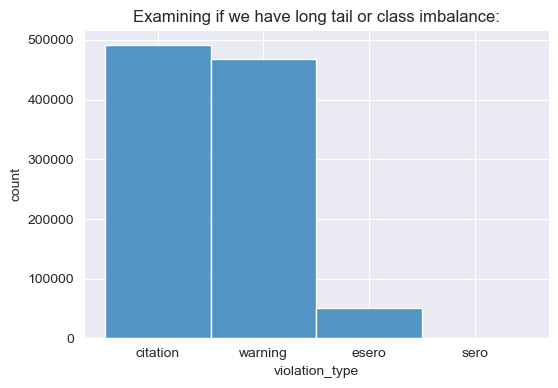

In [ ]:
print(df['violation_type'].value_counts(normalize= True))

plt.figure(figsize=(6, 4))
sns.histplot(df["violation_type"])
plt.ylabel('count')
plt.xlabel('violation_type')
plt.title('Examining if we have class imbalance:')
plt.show()

options: \
1- SMOTE is out the question, it will try to create 496,695*60 = 298,071 samples out of 916 * 60 = 550 samples in the train set, to match the largest class. Also, very few samples in val and test set will be left. \
**2- Under sample the abundant class > can try this** \
3- Resample each class differently starting with 1:1 ratio of abundant and rare classes, while slowly increasing abundant class ratio. \
4- XGBoost will automatically take care of it to some extent, but for linear and logistic regression and RF, this class will be completely ignored during training. \
5- Create custom ensemble models > out of scope of project \
**6- K-medoid clustering, that will create 4 clusters and only take the points around center of custer is a good idea, even though it will drastically reduce the size of the dataset, possibly leaving around 900-1000 samples in each class > possible to try if memory doesn't run out** \
**7- Combining does make sense as it is a repair order for vehicle. SERO: Safety equipment repair order, ESORO: Safety equipment repair order. Later, another binary model can predict SERO/ESORO once we have the category overall > model chaining** 
8- **Dropping SERO for now** 

Will explore when about to train to see effect of changing target variable.

Cleaning up features:

In [ ]:
states_list = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


states_list =  [i.lower() for i in states_list]
print(len(states_list))

# States are still not fixed, correcting them by comparing with lowercased 50 state name abbreivations, 
# and categorizing all others as unknows:
state_col = ["state", "dl_state", "driver_state"]
for col in state_col:
    df[col] = df[col].apply(lambda x: x if x in states_list else "unk")

print(df[state_col].apply(lambda col: col.nunique()))

51
state           52
dl_state        52
driver_state    52
dtype: int64


In [108]:
# convert all boolean columns to 0 and 1
col_bool = ["belts","personal_injury","property_damage","fatal","commercial_license" ,"hazmat",
"commercial_vehicle" ,"alcohol","work_zone","contributed_to_accident"]     

for col in col_bool:
    df[col] = (df[col] == 'yes').astype(int)

In [109]:
df["season_of_stop"] = df["date_of_stop"].str[:2]
df["season_of_stop"]= pd.to_numeric(df["season_of_stop"], errors='coerce')
df["season_of_stop"]= df.season_of_stop.apply(lambda x:x if x!=12 else 0)
b = [0,3,6,9,12]
l = ['winter', 'spring','summer','fall']
df["season_of_stop"] = pd.cut(df["season_of_stop"], bins=b, labels=l, include_lowest=True, ordered=False)
df = df.drop(columns="date_of_stop")
df["season_of_stop"].unique()

['summer', 'winter', 'spring', 'fall']
Categories (4, object): ['winter', 'spring', 'summer', 'fall']

In [110]:
df["hour_of_stop"] = df["time_of_stop"].str[:2]
df["hour_of_stop"]= pd.to_numeric(df["hour_of_stop"], errors='coerce')
b = [0,4,8,12,16,20,24]
l = ['late_night', 'early_morning','morning','noon','eve','night']
# time_bins = [0,4,12,16,20,24]
# time_labels = ['night','morning','afteroon','evening','night']
df["hour_of_stop"] = pd.cut(df["hour_of_stop"], bins=b, labels=l, include_lowest=True, ordered=False)
df = df.drop(columns = ["time_of_stop"])
df["hour_of_stop"].unique()

['eve', 'late_night', 'night', 'noon', 'morning', 'early_morning']
Categories (6, object): ['late_night', 'early_morning', 'morning', 'noon', 'eve', 'night']

C:\Users\Mona\AppData\Local\Temp\ipykernel_16392\1302223209.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["year"])


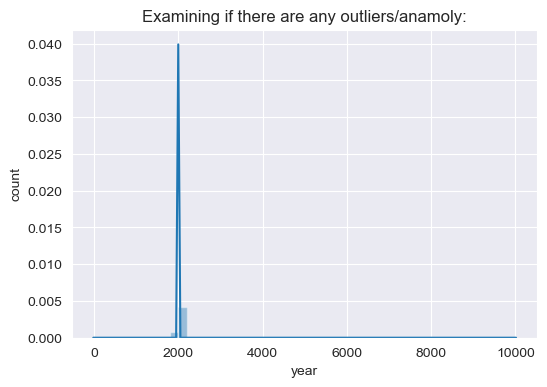

In [111]:
plt.figure(figsize=(6, 4))
sns.distplot(df["year"])
plt.ylabel('count')
plt.xlabel('year')
plt.title('Examining if there are any outliers/anamoly:')
plt.show()

it seems there are some outliers at 0 and 1000, doing a common sense check before using some more preprocesing after train set has been created, that is removing outlires based on 1st and 3rd quantiles, using IQR will reomove outliers after 2022, but 

In [112]:
df["year"] = df["year"].apply(lambda x: float("nan") if (x > 2022 or x < 0) else x)

# now converting car from year to age:
df["car_age"] = 2022-df["year"]
df = df.drop(columns="year")

Missing values will be dealt with after train test split:

In [113]:
# saving df as csv:
df.to_csv("cleaned_traffic_violations.csv", index=False)

# Using cleaned dataset for further feature engineering and feature importance using train set:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# from sklearnex import patch_sklearn, config_context
# patch_sklearn()

c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("cleaned_traffic_violations.csv")

# Giving the dimension information
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (1010737, 28)


In [2]:
# Dataset informations, missing and unique values:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'datatype'})

tab_info=pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).
                        T.rename(index={0:'missing values'})], axis=0)

percentage_missing = (df.isnull().sum()/df.shape[0]*100).round(4)
tab_info=pd.concat([tab_info, pd.DataFrame(percentage_missing)
                         .T.rename(index={0:'missing value %'})], axis=0)

tab_info=pd.concat([tab_info, pd.DataFrame(df.nunique())
                        .T.rename(index={0:'number of unique values'})], axis=0)

df_unique = df.apply(lambda col: col.unique())
tab_info=pd.concat([tab_info, pd.DataFrame(df_unique)
                        .T.rename(index={0:'unique values'})], axis=0)

tab_info.T


Dataframe dimensions: (1010737, 28)


,datatype,missing values,missing value %,number of unique values,unique values
subagency,object,0,0.0,7,"[3rd_district,_silver_spring, 2nd_district,_be..."
belts,int64,0,0.0,2,"[0, 1]"
personal_injury,int64,0,0.0,2,"[0, 1]"
property_damage,int64,0,0.0,2,"[0, 1]"
fatal,int64,0,0.0,2,"[0, 1]"
commercial_license,int64,0,0.0,2,"[0, 1]"
hazmat,int64,0,0.0,2,"[0, 1]"
commercial_vehicle,int64,0,0.0,2,"[0, 1]"
alcohol,int64,0,0.0,2,"[0, 1]"
work_zone,int64,0,0.0,2,"[0, 1]"


In [3]:
# # Safety Equipment Repair Orders (SERO)
# # Electric Vehicle safety equipment repair orders 

# # # To delete SERO:
# df = df[df.violation_type!= 'sero']

# # # Combine SERO and ESERO into ERO
df['violation_type'] = df['violation_type'].apply(lambda x:x if (x!="sero" and x!="esero") else "ero")
print(df.violation_type.value_counts(normalize=True))

# label encoding target first:
from sklearn.preprocessing import LabelEncoder

target = df["violation_type"]
le = LabelEncoder()
target = le.fit_transform(target)
# list(le.classes_)
# le.transform(["tokyo", "tokyo", "paris"])
# list(le.inverse_transform([2, 2, 1]))
np.unique(target)

citation    0.486215
warning     0.462300
ero         0.051485
Name: violation_type, dtype: float64


array([0, 1, 2])

In [4]:
features = df.drop(columns = "violation_type").copy()
features.columns

Index(['subagency', 'belts', 'personal_injury', 'property_damage', 'fatal',
       'commercial_license', 'hazmat', 'commercial_vehicle', 'alcohol',
       'work_zone', 'state', 'vehicletype', 'make', 'model', 'color', 'charge',
       'article', 'contributed_to_accident', 'race', 'gender', 'driver_city',
       'driver_state', 'dl_state', 'arrest_type', 'season_of_stop',
       'hour_of_stop', 'car_age'],
      dtype='object')

In [41]:
# do train test split here:

from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

splits = [x_train_full, x_train, x_val, x_test]
for split in splits:
        # split.reset_index(inplace = True)
        split.reset_index(drop=True, inplace=True)

# splits = [y_train_full,y_train, y_val, y_test]
# for split in splits:
#          split.reset_index(drop = True, inplace = True)

fixing car age outliers based on train set:

IQR value for car_age is: 9.0
-1.5 34.5


C:\Users\Mona\AppData\Local\Temp\ipykernel_7340\238537641.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train["car_age"])


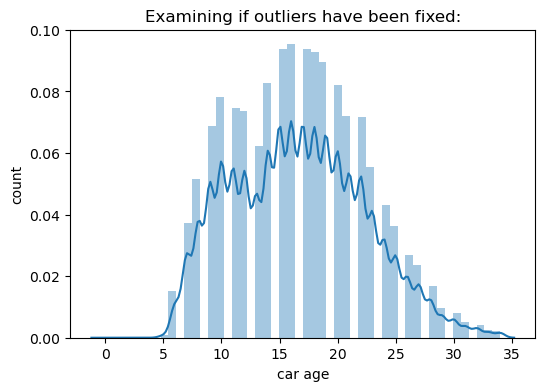

In [42]:
'''
since the curve besides the outliers look normal, we'll use the fact that most observations will lie within three standard deviations. Anything outside is an outlier:
'''
Q1 = x_train["car_age"].quantile(0.25)
Q3 = x_train["car_age"].quantile(0.75)
IQR = Q3 - Q1
print("IQR value for car_age is: %s" %IQR)

lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
print(lower_range, upper_range)

x_train["car_age"] = x_train["car_age"].apply(lambda x:x if (x >= lower_range and x <= upper_range) else float("nan"))

plt.figure(figsize=(6, 4))
sns.distplot(x_train["car_age"])
plt.ylabel('count')
plt.xlabel('car age')
plt.title('Examining if outliers have been fixed:')
plt.show()



data is pretty much normal so no log tranform or standard scaling 

In [43]:
x_val["car_age"] = df.car_age.apply(lambda x: float("nan") if (x > upper_range or x < lower_range) else x)
x_test["car_age"] = df.car_age.apply(lambda x: float("nan") if (x > upper_range or x < lower_range) else x)

In [44]:
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype

# running this on df, as missing values MIGHT end up only in one of the splits
all_missing_columns = df.columns[df.isnull().any()].tolist()


for col in all_missing_columns:
    if (is_object_dtype(df[col])):
        x_train[col].fillna(x_train[col].mode()[0], inplace=True)
        x_val[col].fillna(x_train[col].mode()[0], inplace=True)
        x_test[col].fillna(x_train[col].mode()[0], inplace=True)

    if (is_numeric_dtype(df[col])):
        x_train[col].fillna(x_train[col].median(), inplace=True)
        x_val[col].fillna(x_train[col].median(), inplace=True)
        x_test[col].fillna(x_train[col].median(), inplace=True)


REDUCE CARDINALITY!

In [10]:
# help taken from: https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b
from collections import Counter

def cumulatively_categorise(column,threshold_cumulative_freq=0.75):

  threshold_value=int(threshold_cumulative_freq*len(column))
  categories_list=[]
  s=0
  counts=Counter(column)

  for i,j in counts.most_common():
    s+=dict(counts)[i]
    categories_list.append(i)
    if (s >= threshold_value):
      break

  categories_list.append('other')
  new_column = column.apply(lambda x: x if (x in categories_list) else 'other')
  return new_column, categories_list

categorical_columns = x_train.select_dtypes(include=["object_", "category"]).columns


for col in categorical_columns:
  initial_categories = len(x_train[col].unique().tolist())

  if (initial_categories > 8 and initial_categories < 35):

    x_train[col], categories_in_column = cumulatively_categorise(x_train[col], threshold_cumulative_freq= 0.8)
    print ("%s has a total of %d categories instead of %d categories after dimensionality reduction\n" 
          %(col, len(categories_in_column), initial_categories))
    
    x_val[col] = x_val[col] .apply(lambda x: x if (x in categories_in_column) else 'other')
    x_test[col] = x_test[col] .apply(lambda x: x if (x in categories_in_column) else 'other')

  if initial_categories >= 35:

      x_train[col], categories_in_column = cumulatively_categorise(x_train[col], threshold_cumulative_freq= 0.7)
      print ("%s has a total of %d categories instead of %d categories after dimensionality reduction\n" 
            %(col, len(categories_in_column), initial_categories))
      
      x_val[col] = x_val[col] .apply(lambda x: x if (x in categories_in_column) else 'other')
      x_test[col] = x_test[col] .apply(lambda x: x if (x in categories_in_column) else 'other')
    
        
  


# i think select kbest will automaically deal later, just threshold at some cumulative freq, not number of categorical_features
# as llarrge cardinality, categories smaller, even top 20 won't capture

vehicletype has a total of 2 categories instead of 33 categories after dimensionality reduction

make has a total of 18 categories instead of 2570 categories after dimensionality reduction

model has a total of 88 categories instead of 12578 categories after dimensionality reduction

color has a total of 7 categories instead of 26 categories after dimensionality reduction

charge has a total of 29 categories instead of 908 categories after dimensionality reduction

driver_city has a total of 15 categories instead of 5393 categories after dimensionality reduction

driver_state has a total of 2 categories instead of 52 categories after dimensionality reduction

dl_state has a total of 2 categories instead of 52 categories after dimensionality reduction

arrest_type has a total of 2 categories instead of 19 categories after dimensionality reduction



Model still has too many categories, so repeating again once:

In [11]:
initial_categories = len(x_train["model"].unique().tolist())
x_train["model"], categories_in_column = cumulatively_categorise(x_train["model"], threshold_cumulative_freq= 0.5)
print ("%s has a total of %d categories instead of %d categories after dimensionality reduction\n" 
            %("model", len(categories_in_column), initial_categories))
      
x_val["model"] = x_val["model"] .apply(lambda x: x if (x in categories_in_column) else 'other')
x_test["model"] = x_test["model"] .apply(lambda x: x if (x in categories_in_column) else 'other')

model has a total of 5 categories instead of 88 categories after dimensionality reduction



The thresholds were determined through hit and trial, as to not drastically reduce categories for high caridnality categories, and to reduce the very high cardinality to keep total OHE features <100

In [12]:
# calculating total categorical features after OHE: 
# car_age values which are numeric, 
# and 10 columns are binary so they won't be OHE either (insight using df.info()), and the unique values of binary columns is
# 10*2
x_train.nunique().sum() - x_train.car_age.nunique() - 20

111

After cardinality reduction, let's look at our features now:

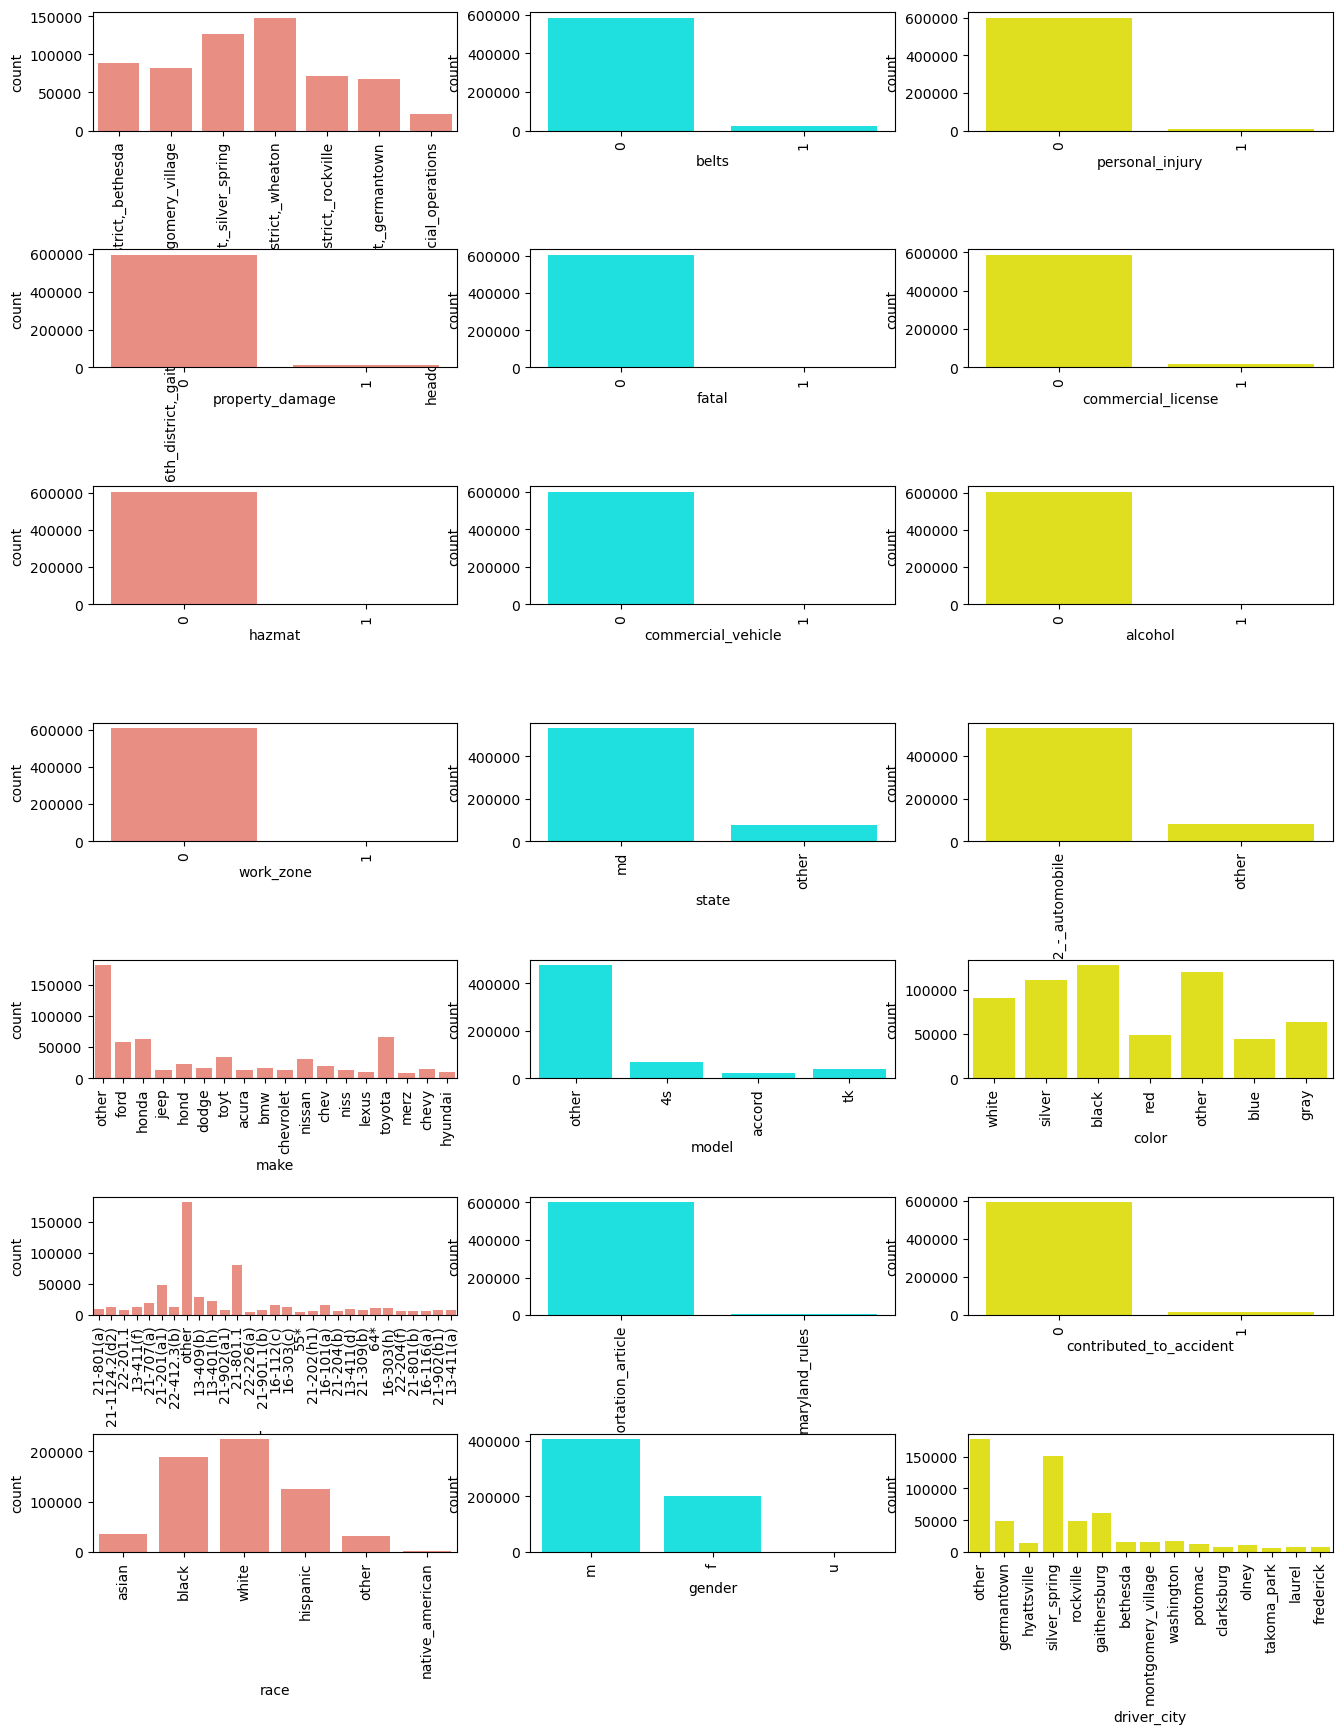

In [26]:
# Let's see the kinds of violations
f, axarr = plt.subplots(7, 3, figsize=(16, 20))
f.subplots_adjust(hspace=1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

colours = ['salmon','cyan','yellow']
k=0
columns_to_plot = x_train.columns.tolist()
columns_to_plot.remove("car_age")

for i in range (7):
    for j in range (3):
        plot = sns.countplot(x = x_train[columns_to_plot[k]], ax=axarr[i][j], color=colours[j])
        # axarr[i][j].set_title(columns_to_plot[k], fontsize=10)
        plt.setp(plot.get_xticklabels(), rotation=90, fontsize=10)
        k +=1


feature importance without fixing missing values yet:
nopes, won't work. Need to do within pipeline

The results are not very promising, so we take a look at feature importance, to reduce some features to see if there can be some improvment:

In [27]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
# X = [['Male', 1], ['Female', 3], ['Female', 2]]
categorical_columns = x_train.select_dtypes(include=["object_", "category"]).columns
x_train_categorical = x_train[categorical_columns]
x_train_OH = enc.fit_transform(x_train_categorical)

# enc.categories_
# enc.transform([['Female', 1], ['Male', 4]]).toarray()
# enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
# enc.get_feature_names_out(['gender', 'group'])


In [28]:
from sklearn.feature_selection import mutual_info_classif  
# < this used for feature selection, mutual info score is a matrix
#only for sicrete, boolean, or OHE featues. Mutual info score on others
# # later in selectk, ill use mutual info classif with one hot encoded features

scores = {}
scores= mutual_info_classif(x_train_OH, y_train, random_state=1)
cat_columns = enc.get_feature_names_out(x_train_categorical.columns)
scores_with_feat_names = dict(zip(cat_columns, scores))
sorted_feat_imp = dict(sorted(scores_with_feat_names.items(), key=lambda item: item[1], reverse = True))
sorted_feat_imp

{'charge_64*': 0.06353242890329676,
 'charge_55*': 0.028852486419901208,
 'charge_16-101(a)': 0.013992527711924916,
 'charge_16-303(c)': 0.0131592881579248,
 'charge_16-303(h)': 0.011765303087381392,
 'charge_21-201(a1)': 0.009401659887170219,
 'charge_21-902(b1)': 0.009195215955300685,
 'charge_21-902(a1)': 0.008854561289935734,
 'charge_21-801.1': 0.007900614694317215,
 'state_other': 0.006999827743895408,
 'state_md': 0.006999827743895407,
 'arrest_type_a_-_marked_patrol': 0.006482598174385443,
 'arrest_type_other': 0.006482598174385443,
 'charge_21-707(a)': 0.005310853510896482,
 'charge_13-409(b)': 0.005020643000841041,
 'charge_21-801(b)': 0.004600878624144959,
 'charge_22-201.1': 0.0044218441340097454,
 'charge_22-226(a)': 0.0042855212281022416,
 'charge_22-204(f)': 0.00427292980174164,
 'hour_of_stop_night': 0.004203631537456162,
 'article_maryland_rules': 0.003920653305792444,
 'article_transportation_article': 0.003920653305792443,
 'race_hispanic': 0.0038810893960333423,
 'c

none has 0 value to indicate no relation to target variable, but some features can be eliminated since their mutual_info_classif score is very small. However, instead of manual removal (which is hard todo once OHE is done, we'll use sklearn pipeline to bring all the steps in phase 2 together.)

In [30]:
y_train_series = pd.Series(y_train) 
correlation = x_train["car_age"].corr(y_train_series)
abs(correlation)


0.05339479403969725

The Pearson correlation measures the strength of the linear relationship between two variables. It has a value between -1 to 1, with a value of -1 meaning a total negative linear correlation, 0 being no correlation, and + 1 meaning a total positive correlation.

for now, we go ahead and get a baseline result with all features, and later in sklearn pipeline, we'll select best k features based on mutual info classification

need to use OHE in pipeline, instead of this to sep categorical variables and to rank them


# Final model training and selecting using sklearn pipeline

now we'll use sklearn pipelines to automate both caridnality reduction? no. cuz min freq or max class don't cut it, so just OneHotEncoder
and also, feature selection. Select best 100-150 features. 

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# from sklearnex import patch_sklearn, config_context
# patch_sklearn()

In [22]:
df = pd.read_csv("cleaned_traffic_violations.csv")

# Giving the dimension information
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (1010737, 28)


citation    0.486215
warning     0.462300
ero         0.051485
Name: violation_type, dtype: float64
citation    0.486215
warning     0.462300
ero         0.051485
Name: violation_type, dtype: float64


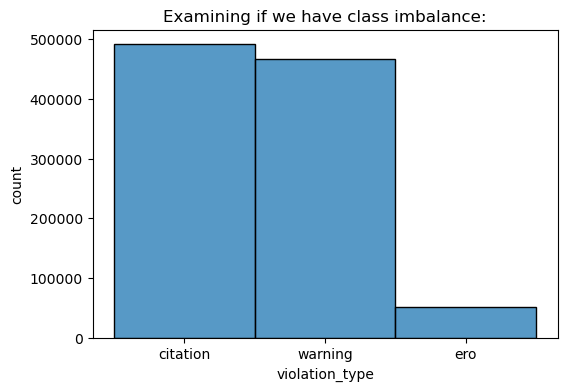

In [23]:
from sklearn.preprocessing import LabelEncoder

# Safety Equipment Repair Orders (SERO)
# Electric Vehicle safety equipment repair orders 

# Option 1: To delete SERO:
# df = df[df.violation_type!= 'sero']

# Option 2: To Combine SERO and ESERO into ERO
df['violation_type'] = df['violation_type'].apply(lambda x:x if (x!="sero" and x!="esero") else "ero")
print(df.violation_type.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.histplot(df["violation_type"])
plt.ylabel('count')
plt.xlabel('violation_type')
plt.title('Examining if we have class imbalance:')
plt.show()



In [ ]:
target = df["violation_type"]
le = LabelEncoder()
target = le.fit_transform(target)

# list(le.classes_)
# le.transform(["tokyo", "tokyo", "paris"])
# list(le.inverse_transform([2, 2, 1]))
np.unique(target)


In [4]:
features = df.drop(columns = "violation_type").copy()
features.columns

Index(['subagency', 'belts', 'personal_injury', 'property_damage', 'fatal',
       'commercial_license', 'hazmat', 'commercial_vehicle', 'alcohol',
       'work_zone', 'state', 'vehicletype', 'make', 'model', 'color', 'charge',
       'article', 'contributed_to_accident', 'race', 'gender', 'driver_city',
       'driver_state', 'dl_state', 'arrest_type', 'season_of_stop',
       'hour_of_stop', 'car_age'],
      dtype='object')

In [5]:
x_train_full, x_test, y_train_full, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

splits = [x_train_full, x_train, x_val, x_test]
for split in splits:
        split.reset_index(drop=True, inplace=True)

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import xgboost as xgb


# def create_model_pipeline(use_cat_OHE = False, use_cat_OE = False, use_dmatrix = False):
def create_model_pipeline(use_cat_OHE = False, use_cat_OE = False):

    categorical_columns = x_train_full.select_dtypes(include=["object_", "category"]).columns.tolist()
    boolean_columns = x_train_full.select_dtypes(include=["number"]).columns.tolist()
    boolean_columns.remove("car_age")
    numerical_columns = ["car_age"]

    boolean_transformer = SimpleImputer(strategy='most_frequent') 

    numerical_imputer = SimpleImputer(strategy="mean")
    numerical_robust_scaler = RobustScaler()
    numerical_transformer = Pipeline(
            steps = [("numerical_imputer", numerical_imputer),("scaler", numerical_robust_scaler),],
            verbose = True
    )

    categorical_imputer = SimpleImputer(strategy='most_frequent')
    categorical_OHE_encoder = OneHotEncoder(max_categories = 30, drop = None, sparse=True, handle_unknown="ignore")
    categorical_ordinal_encoder = OrdinalEncoder()

    # deciding whether to encode categroical feature as OHE or ordinal features
    if use_cat_OHE == True:
        categorical_transformer = Pipeline(
            steps = [("categorical_imputer", categorical_imputer),("OHE_encoder", categorical_OHE_encoder),
            ],
            verbose = True
        )

    elif use_cat_OE == True:
        categorical_transformer = Pipeline(
            steps = [("categorical_imputer", categorical_imputer),("OE_encoder", categorical_ordinal_encoder),
            ],
            verbose = True
        )
    else:
        categorical_transformer = categorical_imputer

    preprocess = ColumnTransformer(
        transformers=[("bool", boolean_transformer, boolean_columns),
            ("num", numerical_transformer, numerical_columns),
            ("cat", categorical_transformer, categorical_columns),
        ],
        verbose = True, remainder='passthrough', n_jobs = -1
    )
    
    # toggling feature selection on and off:
    if use_cat_OE == True:
        model_pipeline = Pipeline(
            steps = [
                ('preprocess', preprocess),
                # ('vectorizer', DictVectorizer())
                # ('feature_selection', SelectKBest(score_func = mutual_info_classif, k =100)),
                
            ],
            verbose = True
        )
    else:
        model_pipeline = Pipeline(
            steps = [
                ('preprocess', preprocess),
                # ('vectorizer', DictVectorizer())
                ('feature_selection', SelectKBest(score_func = mutual_info_classif, k =100)),
                
            ],
            verbose = True
        )
    # if use_dmatrix == True:
    #     dtrain = xgb.DMatrix()
    #     model_pipeline.steps.append('dtrain', dtrain) #insert as second step

        

    return model_pipeline


In [20]:
# to visualize pipeline so far:
model_pipeline = create_model_pipeline(use_cat_OHE= True)
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('bool',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['belts', 'personal_injury',
                                                   'property_damage', 'fatal',
                                                   'commercial_license',
                                                   'hazmat',
                                                   'commercial_vehicle',
                                                   'alcohol', 'work_zone',
                                                   'contributed_to_accident']),
                                                 ('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleIm...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 max_categories=30))],
                                                           verbose=True),
                                                  ['subagency', 'state',
                                                   'vehicletype', 'make',
                                                   'model', 'color', 'charge',
                                                   'article', 'race', 'gender',
                                                   'driver_city',
                                                   'driver_state', 'dl_state',
                                                   'arrest_type',
                                                   'season_of_stop',
                                                   'hour_of_stop'])],
                                   verbose=True)),
                ('feature_selection',
                 SelectKBest(k=100,
                             score_func=<function mutual_info_classif at 0x0000026795A58D30>))],
         verbose=True)

we havent added classifier yet, becuase we'll be working with different classifiers and we will need to change them.

## Defining some useful functions:

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_validate

def do_stratifed_kfold_cv(model_pipeline, x_train_full, y_train_full):    
    cv_outer = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    scores = cross_validate(model_pipeline, x_train_full, y= y_train_full, scoring="balanced_accuracy", cv=cv_outer, 
                n_jobs=-1, verbose=1)
    return scores

In [8]:
from sklearn.metrics import balanced_accuracy_score, precision_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def model_predict_scores(model_pipeline, x_val, y_val, le):
    
    y_pred = model_pipeline.predict(x_val)
    
    print("balanced accuracy socre is:", round(balanced_accuracy_score(y_val, y_pred), 3))
    print("precision of model is:",round(precision_score(y_val, y_pred, average='weighted'),3))
    print("RMSE of model is",round(mean_squared_error(y_val, y_pred, squared=False),3))
    print(classification_report(y_val, y_pred))

    label_string = le.classes_
    y_val_string = le.inverse_transform(y_val)
    y_pred_string = le.inverse_transform(y_pred)

    cm = confusion_matrix(y_val_string, y_pred_string, labels=label_string, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_string)
    disp.plot()
    plt.grid(None)
    plt.show()

    


In [10]:
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

def random_grid_search(model_pipeline, distributions, x_train, y_train ):
    
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)                            

    # search = GridSearchCV(model, space, scoring='balanced_accuracy', n_jobs=1, cv=cv_inner, refit=True)
    search = RandomizedSearchCV(model_pipeline, distributions, scoring="balanced_accuracy", n_jobs= -1, cv=cv_inner, 
                refit=True, random_state=1, verbose=1)
    search.fit(x_train, y_train)
    print ("Best params are:", search.best_params_)
    print ("Validation set balanced_accuracy score on best params is:", search.best_score_)

    # if any cross-validation, it would make sense here but then I cannot best_params_
    # potential link:
    # however, gridsearch is already on cross validated, so enough. 
    # and doing non-nested cross validation for the sake of it is just going to show inflated results. Best to use just test set

## Fine-tuning and testing Logistic Regression:

In [52]:
from sklearn.linear_model import LogisticRegression


model_pipeline = create_model_pipeline(use_cat_OHE= True)
model_for_classification = (LogisticRegression(random_state=42, n_jobs= -1))
model_pipeline.steps.insert(2,('classification', model_for_classification)) #insert as second step

# Do a random grid search to get best params:
# add lgfs and max_iter
distributions = {'classification__max_iter': [300, 500],
                'classification__solver':["lbfgs", "sag", "saga"],
                'classification__C': [0.9, 1],
}
random_grid_search(model_pipeline, distributions, x_train, y_train )

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  16.6s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 3) Processing feature_selection, total=  40.0s
[Pipeline] .... (step 3 of 3) Processing classification, total= 1.6min
Best params are: {'classification__solver': 'lbfgs', 'classification__max_iter': 500, 'classification__C': 1}
Validation set balanced_accuracy score on best params is: 0.6627305036106601


[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  25.8s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 3) Processing feature_selection, total=  56.3s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] .... (step 3 of 3) Processing classification, total= 2.5min

Results on the test set are: 
balanced accuracy socre is: 0.661
precision of model is: 0.7
RMSE of model is 1.087
              precision    recall  f1-score   support

           0       0.72      0.63      0.67     98287
           1       0.97      0.59      0.74     10408
           2       0.65      0.76      0.70     93453

    accuracy                           0.69    202148
   macro avg       0.78      0.66      0.70    202148
weighted avg       0.70      0.69      0.69    202148



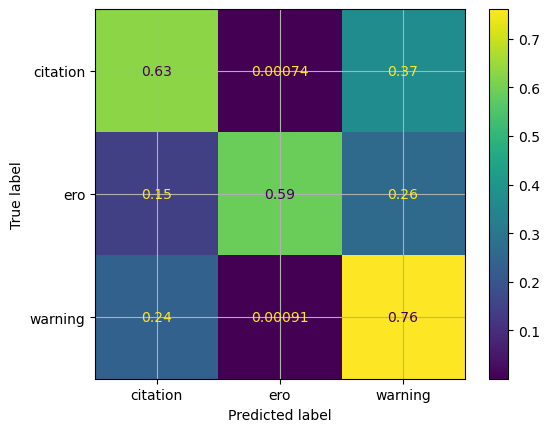

In [ ]:
# create pipeline with fine-tuned hyper-paramter of the model:
model_pipeline = create_model_pipeline(use_cat_OHE= True)
tuned_model_classification = LogisticRegression(random_state=42, max_iter=500, solver = 'lbfgs', C=1.0, n_jobs= -1)
model_pipeline.steps.insert(2,('classification', tuned_model_classification)) #insert as second step

# train with fine tuned hyper-params:
model_pipeline.fit(x_train, y_train)

# test the model on withheld dataset:
print("\nResults on the test set are: ")
model_predict_scores(model_pipeline, x_val, y_val, le) 

In [ ]:
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('bool',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['belts', 'personal_injury',
                                                   'property_damage', 'fatal',
                                                   'commercial_license',
                                                   'hazmat',
                                                   'commercial_vehicle',
                                                   'alcohol', 'work_zone',
                                                   'contributed_to_accident']),
                                                 ('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleIm...
                                                   'model', 'color', 'charge',
                                                   'article', 'race', 'gender',
                                                   'driver_city',
                                                   'driver_state', 'dl_state',
                                                   'arrest_type',
                                                   'season_of_stop',
                                                   'hour_of_stop'])],
                                   verbose=True)),
                ('feature_selection',
                 SelectKBest(k=100,
                             score_func=<function mutual_info_classif at 0x00000175AC533880>)),
                ('classification',
                 LogisticRegression(max_iter=200, random_state=42,
                                    solver='sag'))],
         verbose=True)

## Fine-tuning and testing Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

model_pipeline = create_model_pipeline(use_cat_OHE = True)
model_for_classification = RandomForestClassifier(random_state=42, n_jobs= -1)
model_pipeline.steps.insert(2,('classification', model_for_classification)) #insert as second step

distributions = {
    'classification__n_estimators': [200, 400],
    # 'classification__max_features': ["sqrt", "log2"],
    'classification__max_depth': [8,10],
    # 'classification__min_samples_leaf': [20,50],
    # 'classification__criterion': ["gini", "entropy"],
}

random_grid_search(model_pipeline, distributions, x_train, y_train )

c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  23.1s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 3) Processing feature_selection, total=  56.2s
[Pipeline] .... (step 3 of 3) Processing classification, total= 3.6min
Best params are: {'classification__n_estimators': 400, 'classification__max_depth': 10}
Validation set balanced_accuracy score on best params is: 0.6466159613009199


[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  25.1s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 3) Processing feature_selection, total=  59.9s
[Pipeline] .... (step 3 of 3) Processing classification, total= 3.5min

Results on the test set are: 
balanced accuracy socre is: 0.646
precision of model is: 0.707
RMSE of model is 1.112
              precision    recall  f1-score   support

           0       0.77      0.53      0.63     98287
           1       1.00      0.57      0.73     10408
           2       0.61      0.84      0.71     93453

    accuracy                           0.67    202148
   macro avg       0.79      0.65      0.69    202148
weighted avg       0.71      0.67      0.67    202148



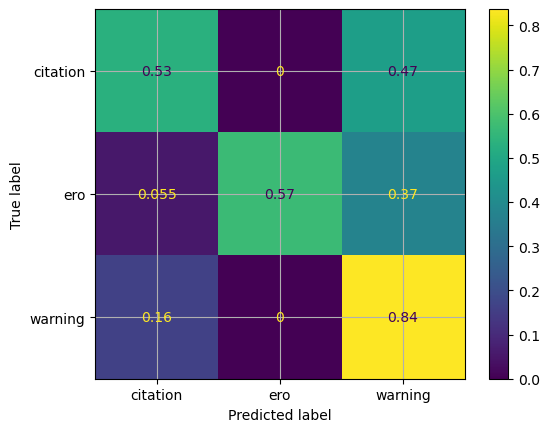

In [110]:
# create pipeline with fine-tuned hyper-paramter of the model:
model_pipeline = create_model_pipeline()
tuned_model_classification = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42, n_jobs= -1)
model_pipeline.steps.insert(2,('classification', tuned_model_classification)) #insert as second step

# train with fine tuned hyper-params:
model_pipeline.fit_transform(x_train, y_train)

# test the model on withheld dataset:
print("\nResults on the test set are: ")
model_predict_scores(model_pipeline, x_val, y_val, le) 

In [ ]:
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('bool',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['belts', 'personal_injury',
                                                   'property_damage', 'fatal',
                                                   'commercial_license',
                                                   'hazmat',
                                                   'commercial_vehicle',
                                                   'alcohol', 'work_zone',
                                                   'contributed_to_accident']),
                                                 ('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleIm...
                                                   'model', 'color', 'charge',
                                                   'article', 'race', 'gender',
                                                   'driver_city',
                                                   'driver_state', 'dl_state',
                                                   'arrest_type',
                                                   'season_of_stop',
                                                   'hour_of_stop'])],
                                   verbose=True)),
                ('feature_selection',
                 SelectKBest(k=100,
                             score_func=<function mutual_info_classif at 0x00000175AC533880>)),
                ('classification',
                 RandomForestClassifier(max_depth=10, n_estimators=400,
                                        n_jobs=-1, random_state=42))],
         verbose=True)

## Fine-tuning and testing XGBoostClassifer

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score


model_pipeline = create_model_pipeline(use_cat_OHE = True)
Xt = model_pipeline.fit_transform(x_train, y_train)
X_val_t = model_pipeline.transform(x_val)

scores = []
for learning_rate in [ 0.01, 0.03]:
    for max_depth in [10, 20]:
        for n_estimators in [100, 200]:   

            model = XGBClassifier(objective='multi:softmax',learning_rate=learning_rate, max_depth=max_depth,n_estimators=n_estimators, 
                        eval_metric=balanced_accuracy_score, n_jobs = -1, random_state=42)

            model.fit(Xt, y_train)
            y_pred = model.predict(X_val_t)

            label_string = le.classes_
            y_val_string = le.inverse_transform(y_val)
            y_pred_string = le.inverse_transform(y_pred)
            balanced_accuracy = round(balanced_accuracy_score(y_val, y_pred), 3)
            scores.append((learning_rate, max_depth, n_estimators, balanced_accuracy))


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=  46.4s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 2) Processing feature_selection, total= 1.5min


In [26]:
columns = ['learning_rate', 'max_depth', 'n_estimators', 'balanced_accuracy']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,learning_rate,max_depth,n_estimators,balanced_accuracy
0,0.01,10,100,0.643
1,0.01,10,200,0.656
2,0.01,20,100,0.673
3,0.01,20,200,0.676
4,0.03,10,100,0.665
5,0.03,10,200,0.675
6,0.03,20,100,0.678
7,0.03,20,200,0.685


[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  18.6s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 3) Processing feature_selection, total=  40.8s
[Pipeline] .... (step 3 of 3) Processing classification, total=10.2min

Results on the test set are: 
balanced accuracy socre is: 0.685
precision of model is: 0.727
RMSE of model is 1.047
              precision    recall  f1-score   support

           0       0.77      0.62      0.69     98287
           1       0.96      0.62      0.75     10408
           2       0.66      0.82      0.73     93453

    accuracy                           0.71    202148
   macro avg       0.79      0.68      0.72    202148
weighted avg       0.73      0.71      0.71    202148



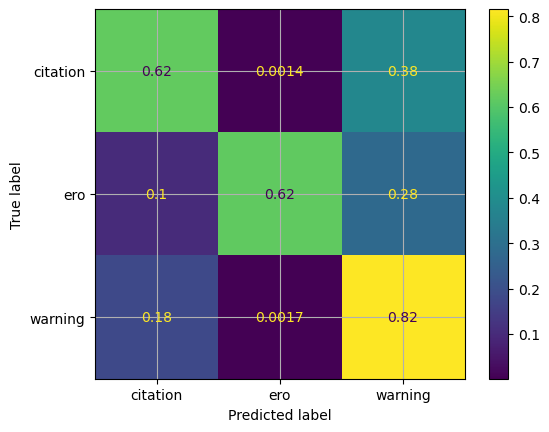

In [14]:
# test the best model on validation set with full pipeline and get scores:
# create pipeline with fine-tuned hyper-paramter of the model:

model_pipeline = create_model_pipeline(use_cat_OHE = True)
tuned_model_classification = XGBClassifier(objective='multi:softmax',learning_rate=0.03, max_depth=20,n_estimators=200, eval_metric=balanced_accuracy_score, n_jobs = -1, random_state=42)
model_pipeline.steps.insert(2,('classification', tuned_model_classification)) #insert as second step

# train with fine tuned hyper-params:
model_pipeline.fit(x_train, y_train)
# test the model on withheld val dataset:
print("\nResults on the test set are: ")
model_predict_scores(model_pipeline, x_val, y_val, le) 

In [28]:
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('bool',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['belts', 'personal_injury',
                                                   'property_damage', 'fatal',
                                                   'commercial_license',
                                                   'hazmat',
                                                   'commercial_vehicle',
                                                   'alcohol', 'work_zone',
                                                   'contributed_to_accident']),
                                                 ('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleIm...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=-1, num_parallel_tree=None,
                               objective='multi:softmax', predictor=None, ...))],
         verbose=True)

# final model:

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=  29.2s


c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


[Pipeline] . (step 2 of 2) Processing feature_selection, total= 1.0min

Results on the test set are: 
balanced accuracy socre is: 0.687
precision of model is: 0.729
RMSE of model is 1.041
              precision    recall  f1-score   support

           0       0.77      0.63      0.69     98287
           1       0.96      0.62      0.75     10408
           2       0.66      0.82      0.73     93453

    accuracy                           0.71    202148
   macro avg       0.80      0.69      0.72    202148
weighted avg       0.73      0.71      0.71    202148



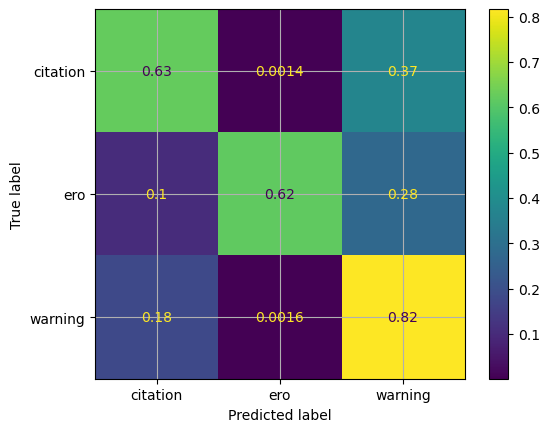

In [16]:
# create pipeline to tansform data and fit the fine-tuned hyper-paramter of the model:
# we do this in two separate steps to be able to save model, because in a pipeline object, I can't rerun final model

model_pipeline = create_model_pipeline(use_cat_OHE = True)
tuned_model_classification = XGBClassifier(objective='multi:softmax',learning_rate=0.03, max_depth=20,n_estimators=200, eval_metric=balanced_accuracy_score, n_jobs = -1, random_state=42)

# train with fine tuned hyper-params:
X_full_t = model_pipeline.fit_transform(x_train_full, y_train_full)
tuned_model_classification.fit(X_full_t, y_train_full)
# test the model on withheld val dataset:
print("\nResults on the test set are: ")
X_test_t = model_pipeline.transform(x_test)
model_predict_scores(tuned_model_classification, X_test_t, y_test, le) 

In [17]:
# Save Model Using joblib
import joblib

filename = 'xgboost_traffic_violation_model.sav'
joblib.dump(tuned_model_classification, filename)
joblib.dump(model_pipeline, 'sklearn_pipeline.pkl')



['sklearn_pipeline.pkl']

In [18]:
loaded_model = joblib.load(filename)
loaded_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function balanced_accuracy_score at 0x00000272DE6C1EA0>,
              feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=20, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', ...)

# Saving model as a BentoML model

In [19]:
import bentoml

bentoml.xgboost.save_model(
    'traffic_violation_classification',
    model,
    custom_objects={
        'model_pipeline': model_pipeline
    },
    signatures= {
        "predict":{
            "batchable": True,
            # we are going to concatenate arrays by first dimension
            "batch_dim": 0,
            
        }
    })

c:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\xgboost\sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(


Model(tag="traffic_violation_classification:sppa6ula76pkuvhb", path="C:\Users\Mona\bentoml\models\traffic_violation_classification\sppa6ula76pkuvhb\")

Getting a test sample from x_test:

In [20]:
import json

request = x_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))


{
  "subagency": "4th_district,_wheaton",
  "belts": 0,
  "personal_injury": 0,
  "property_damage": 0,
  "fatal": 0,
  "commercial_license": 1,
  "hazmat": 0,
  "commercial_vehicle": 0,
  "alcohol": 0,
  "work_zone": 0,
  "state": "md",
  "vehicletype": "02_-_automobile",
  "make": "honda",
  "model": "civic",
  "color": "red",
  "charge": "21-904(b2)",
  "article": "transportation_article",
  "contributed_to_accident": 0,
  "race": "hispanic",
  "gender": "m",
  "driver_city": "silver_spring",
  "driver_state": "md",
  "dl_state": "md",
  "arrest_type": "a_-_marked_patrol",
  "season_of_stop": "summer",
  "hour_of_stop": "late_night",
  "car_age": 28.0
}
